In [1]:
# import everything you need
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

import numpy as np
import pandas as pd
import seaborn as sns

from __future__ import print_function
%matplotlib inline
import mdtraj as md
from mdtraj.formats import PDBTrajectoryFile
import matplotlib.pyplot as plt

In [2]:
# Compute CA-CA distance matrix for a trajectory
def compute_ca_distances(traj):
    """ Compute CA-CA distance matrix for a trajectory. """
    ca_indices = traj.topology.select('(resi 1 to 319) and not type H')
    distances = np.empty((traj.n_frames, len(ca_indices) * (len(ca_indices)-1) // 2))
    
    for i, frame in enumerate(traj.xyz):
        pairwise_distances = np.linalg.norm(frame[ca_indices, np.newaxis, :] - frame[np.newaxis, ca_indices, :], axis=-1)
        # Extract the upper triangle of the distance matrix
        distances[i] = pairwise_distances[np.triu_indices(len(ca_indices), k=1)]
        
    return distances

In [17]:
# Load trajectory
trajs = md.load('traj_inactive.xtc', top='inactive.gro', stride=1000)

In [15]:
# Compute CA-CA distances for each trajectory
traj_distances = []
all_distances = []
traj_dists = compute_ca_distances(trajs)
traj_distances.append(traj_dists)
all_distances.append(traj_dists)
flattened_distances = np.vstack(all_distances)

In [18]:
# Perform PCA
pca = PCA(n_components=5)  # You can change the number of components if you wish
projected_data = pca.fit_transform(flattened_distances)

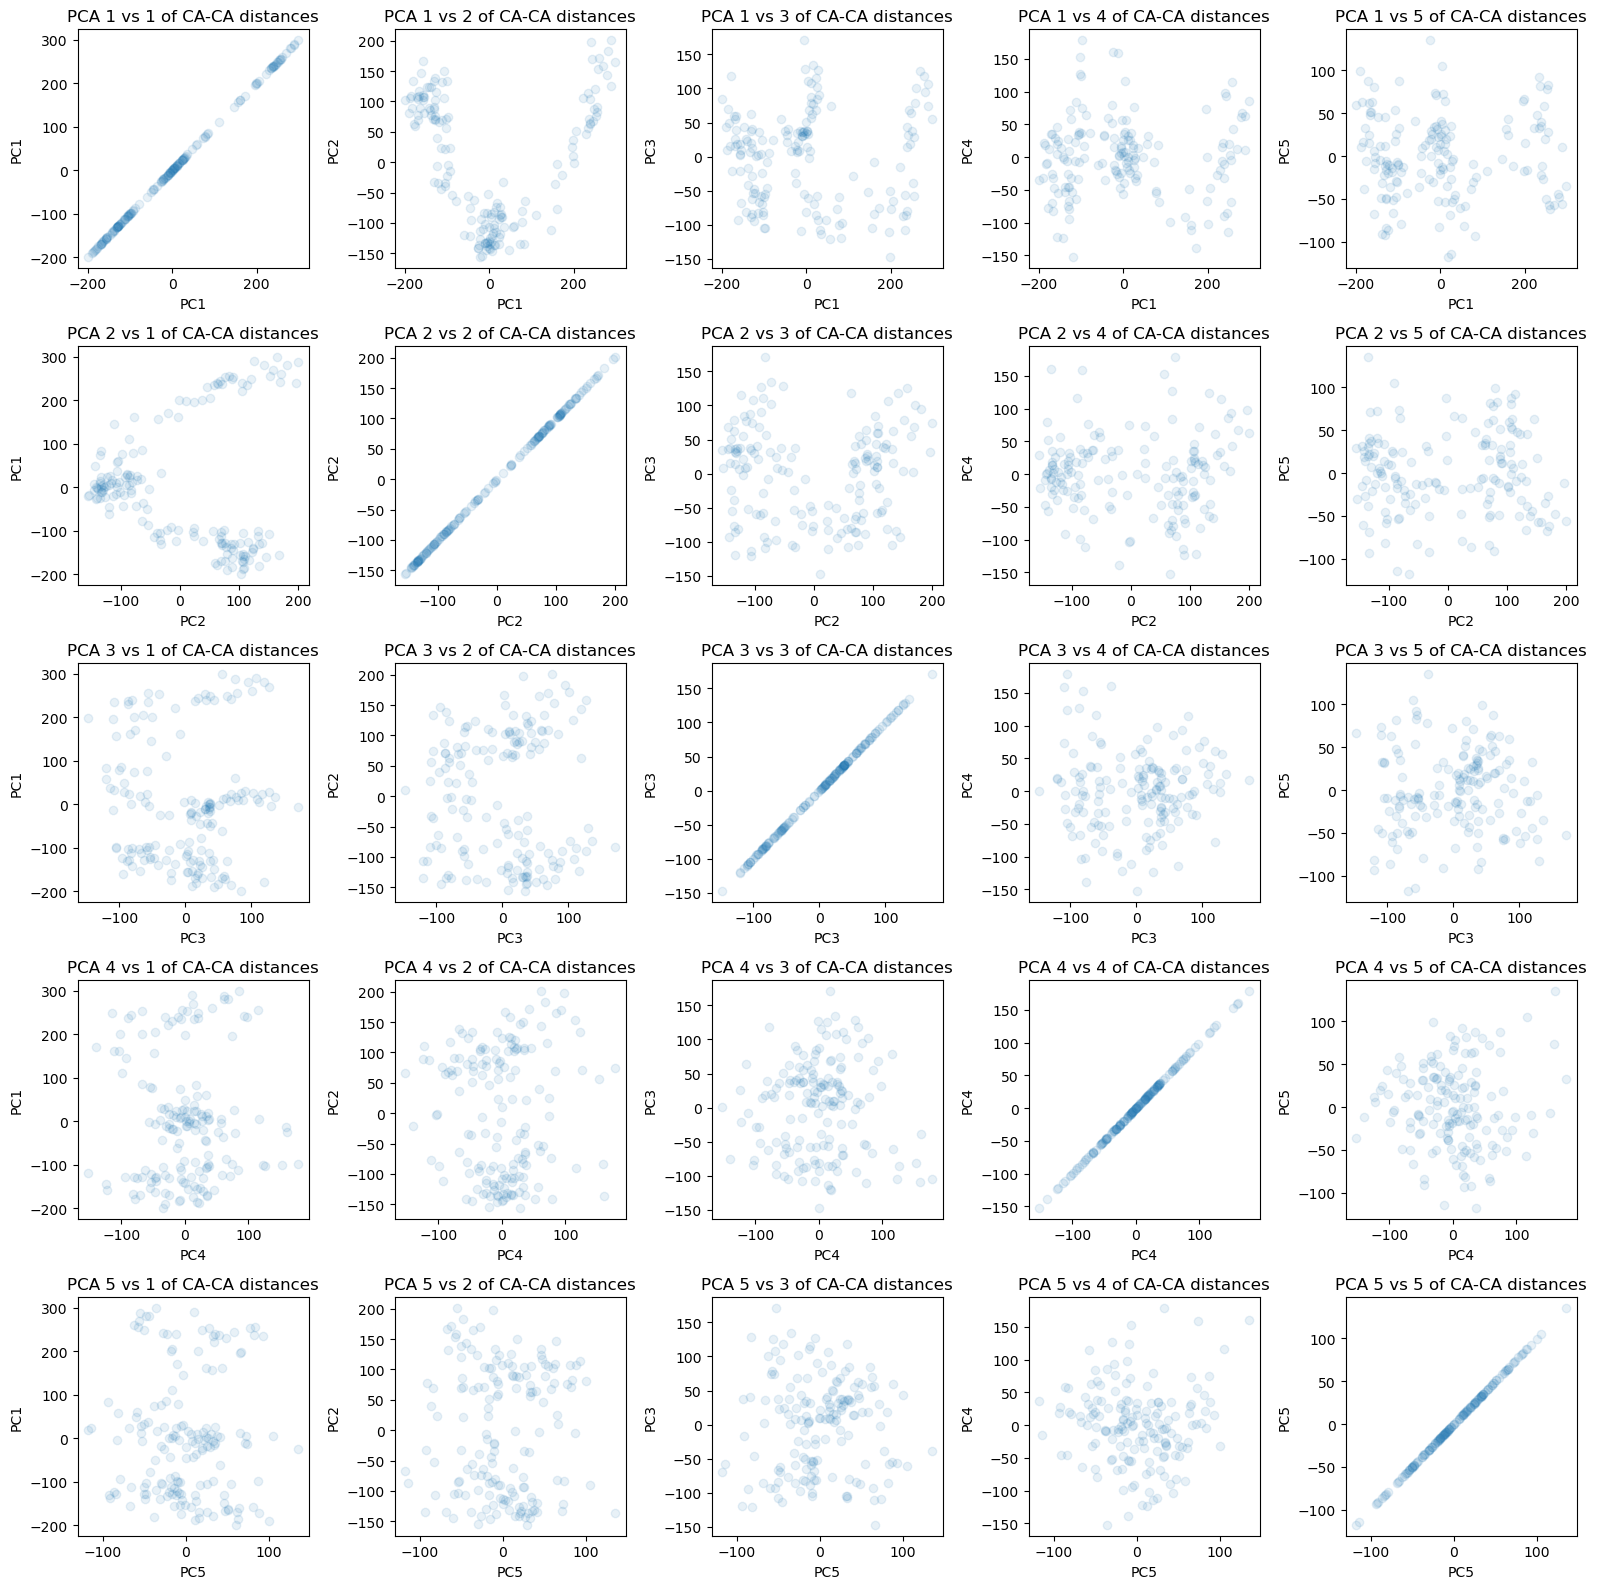

In [19]:
# Create subplots for different combinations of PC(x) vs PC(y)
fig, axs = plt.subplots(5, 5, figsize=(16, 16))

# Iterate through all combinations of PC(x) vs PC(y)
for x in range(5):
    for y in range(5):
        #if x != y:
            pc_x = projected_data[:, x]
            pc_y = projected_data[:, y]

            # Plot PC(x) vs PC(y)
            axs[x, y].scatter(pc_x, pc_y, alpha=0.1)
            axs[x, y].set_xlabel(f'PC{x + 1}')
            axs[x, y].set_ylabel(f'PC{y + 1}')
            axs[x, y].set_title(f'PCA {x + 1} vs {y + 1} of CA-CA distances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [20]:
from sklearn.cluster import KMeans  # You can choose a different clustering algorithm as well

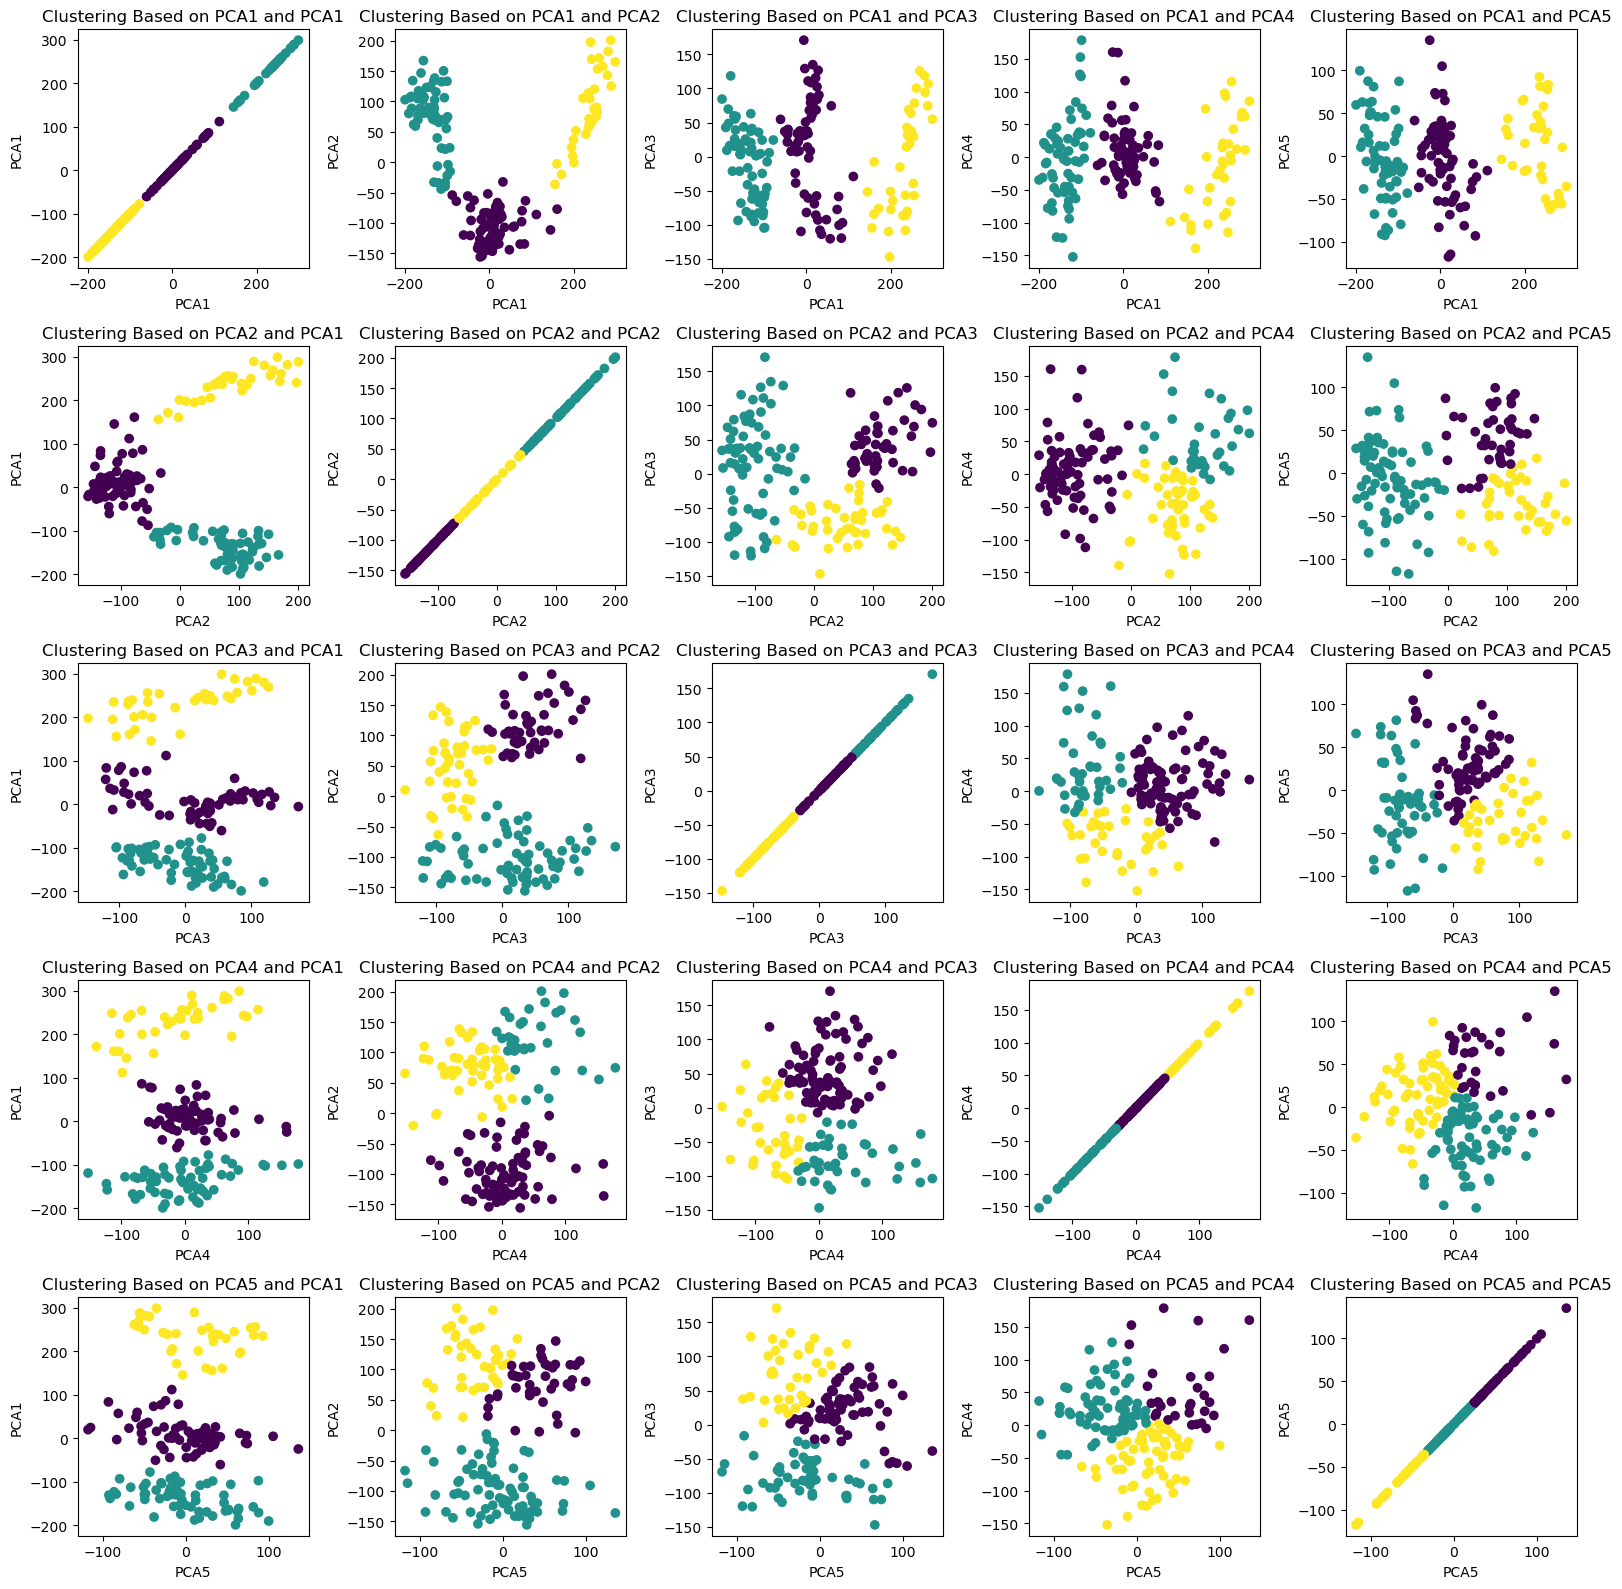

In [21]:
# Number of clusters you want to create
num_clusters = 3  # Adjust this according to your data

# Create subplots
fig, axs = plt.subplots(5, 5, figsize=(16, 16))

# Iterate through all combinations of PCA components
for x in range(5):
    for y in range(5):
        # Combine PCA components into a feature matrix
        X = projected_data[:, [x, y]]
        
        # Initialize the clustering algorithm
        kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
        
        # Fit the clustering model to your data
        kmeans.fit(X)
        
        # Get cluster assignments for each data point
        cluster_labels = kmeans.labels_
        
        # Create a scatter plot with points colored by cluster
        axs[x, y].scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
        axs[x, y].set_xlabel(f'PCA{x + 1}')
        axs[x, y].set_ylabel(f'PCA{y + 1}')
        axs[x, y].set_title(f'Clustering Based on PCA{x + 1} and PCA{y + 1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [23]:
import mdtraj as md
from itertools import combinations
import os

# Assuming you have already obtained projected_data and cluster_labels

# Number of clusters you want to create
num_clusters = 3  # Adjust this according to your data

# Create output directory for PDB files (modify as needed)
output_directory = 'cluster_representatives_a2a_inactive'
os.makedirs(output_directory, exist_ok=True)

# Define the number of PCA components
n_pca_components = 5  # You can change this based on your data

# Iterate through all combinations of PCA components
for x, y in combinations(range(n_pca_components), 2):
    # Combine PCA components into a feature matrix
    pca_data = projected_data[:, [x, y]]

    # Initialize the clustering algorithm
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)

    # Fit the clustering model to your data
    kmeans.fit(pca_data)

    # Get cluster assignments for each data point
    cluster_labels = kmeans.labels_

    # Create a dictionary to store cluster representatives
    cluster_representatives = {}

    # Iterate through clusters and find representatives
    for cluster_id in range(num_clusters):
        cluster_mask = cluster_labels == cluster_id

        # Calculate the distances between the mean structure and all frames in the cluster
        distances = np.linalg.norm(pca_data[cluster_mask] - np.mean(pca_data[cluster_mask], axis=0), axis=1)
        
        # Find the index of the frame with the smallest distance to the mean structure
        closest_frame_index = np.argmin(distances)
        
        # Get the closest frame from the original trajectory (assuming you have 'traj')
        closest_frame = trajs[cluster_mask][closest_frame_index]

        # Save the closest frame as a PDB file
        pdb_filename = f'{output_directory}/PCA_{x+1}_PCA_{y+1}_cluster_{cluster_id}_closest_structure.pdb'
        closest_frame.save(pdb_filename)